## Part 1 implementing QAOA


In [ ]:
!pip install myqlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.3/498.3 KB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 7.

### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

NB: The eigenvalue (so the energy) of this hamiltonian for a particular subgraph S is:

$$ E_{S} = \sum_{i \in S, j \in S}(1-2*1)(1-2*1) +  \sum_{i \in S, j \in E\setminus S}(1-2*1)(1-2*0) + \sum_{i \in S, j \in E\setminus S}(1-2*0)(1-2*0)
\\
= \sum_{i \in S, j \in S}1 +  \sum_{i \in S, j \in E\setminus S}(-1) + \sum_{i \in S, j \in E\setminus S}1
$$ 
Which is minimized when the number of "cut" edges (number of element inside $\left\lbrace (i,j)\in V | \quad  i \in S, j \in E\setminus S \right\rbrace$)  is maximized. 

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1 #Nombre d arretes

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0

    for (i,j) in edges:                   #We check all the edges of the graph 
      val = val + (1-2*b[i])*(1-2*b[j])   #We compute the value of the hamiltonian

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

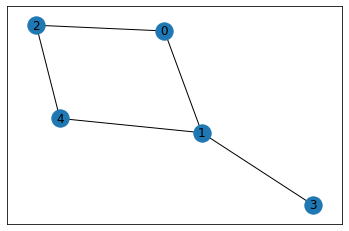

In [ ]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

We know from Question 1 that 
$$H_e(i,j) = \sigma_i \sigma_j $$ 
Where $\sigma_i$ and $\sigma_j$ are rotation on the $z$-axis. So, dealing with the evolution of the system under this hamiltonian is equivalent to apply a $z$-rotation on two different qubits. Hence the need of $U_{zz}$ gate on every edges of the graph.

In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer

    ## COMMENTS
    #     We want to apply the following gates: rotation and temporal evolution 

    for qubit in range(n_qubits):           #Apply a rotation to each qubit
      layer.apply(RX(theta), qubit)

    for binome in edges:            #For every edges of the graphs... 
      q1, q2 = binome
      layer.apply(U_ZZ(beta), q1, q2) #... we apply time evolution under the hamiltonian

    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit

    for n in range(n_qubits):    #initialization
      prog.apply(H, qubits[n])

    for i in range(n_layers):   #We apply a the one_qaoa_layer n_layers times 
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[i*2], parameters[i*2+1]),qubits)
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)

        #We compute the mean value of the observable
        b = sample.state.bitstring #get one state
        val = 0
        for (i,j) in edges :
          val = val+(1-2*int(b[i]))*(1-2*int(b[j]))

        obs = obs+ sample.probability*val #We add the value taking into account the probability

    # END TODO
    return obs
    
        

In [ ]:
import numpy as np
np.random.random(3)

array([0.40211618, 0.86204044, 0.46493177])

In [ ]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question: 8

-2.686096587488641 -3.407857530327894 -3.7913013668822964 -4.352165181833983 -4.557883383026735 -4.6473826344827955 -4.689454164759638 -4.699261277632343 -4.716980627254801 -4.747275686801405 -4.762816200026868 -4.768904211700426 -4.776106172080178 -4.780825596664474 -4.782595922736685 -4.785205337704405 -4.788851602766117 -4.79462434020766 -4.799184516555383 -4.807046867179494 -4.818968004712029 -4.82650760431935 -4.829953392968255 -4.834083295291339 -4.836595163133801 -4.83803579617727 -4.838713241552922 -4.839437120737601 -4.840150954677061 -4.840248484587405 -4.840386388089227 -4.840462614877146 -4.840517270720953 -4.840577242398784 -4.840637525900527 -4.840740602452171 -4.84092311267062 -4.8411715376449385 -4.841477432939292 -4.842022762196985 -4.842634477156187 -4.843583422219438 -4.844397745543969 -4.845601525095109 -4.8463039321638135 -4.847603110429983 -4.849842211245974 -4.852151838479716 -4.854985064544588 -4.857425068145012 -4.858554372623893 -4.85925060072604 -4.8603212641

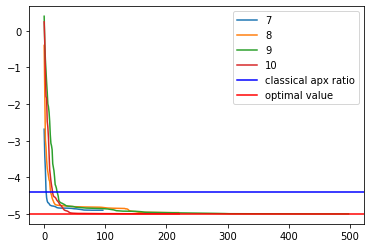

In [ ]:
import matplotlib.pylab as plt

for nlayers in range(7,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

We want to use AQC.

For that, we start from the following hamiltonian $H_0 = \sum_k \sigma_x^k$ whose ground state is known ($\left| \psi_{0} \right>$). Then we study the following hamiltonian:
$$ H(s) = \left( 1-\frac{s}{T}\right) H_0 + \frac{s}{T}H_C$$

From Schrodinger equation, we know that the final state is:

$$ \left| \psi_{final} \right> = e^{-i\int_{0}^{T}H(s)ds}\left| \psi_{0} \right> $$

Using $\int_{0}^{T}H(s)ds = \frac{T}{p} \sum_{k=1}^{p}H\left( \frac{k}{p}T\right)$ and the approximation $e^{A+B} \approx e^{A}e^{B}$, we get:

$$ \left| \psi_{final} \right> ≈ e^{-i \frac{T}{p} \sum_{k=1}^{p}H\left( \frac{k}{p}T\right)}\left| \psi_{0} \right> \approx \left( \prod_{k=1}^{p} e^{-i\frac{T}{p}H\left( \frac{k}{p}T\right)} \right)\left| \psi_{0} \right>$$

So we get :

$$ \left| \psi_{final} \right> \approx \left( \prod_{k=1}^{p} e^{-i\frac{T}{p}\left(\left( 1-\frac{k}{p}\right) H_0 + \frac{k}{p}H_C\right)} \right)\left| \psi_{0} \right> \approx \left( \prod_{k=1}^{p} e^{-i\frac{T}{p}\left( 1-\frac{k}{p}\right) H_0 } e^{-i\frac{T}{p}\frac{k}{p}H_C} \right)\left| \psi_{0} \right> $$

Then, we get $\theta_k = \frac{T}{p}\left( 1-\frac{k}{p}\right)$ and $\beta_k =\frac{T}{p}\frac{k}{p} $

-1.7496724116951932 -2.159163474004655 -2.2257811955427997 -2.3534906208810122 -2.5528847299457524 -2.7240780778780347 -2.874322107691809 -2.8928092113526835 -2.9138062895165358 -2.951885661328576 -3.007218455416463 -3.080013726019793 -3.1692372092004226 -3.2119971532026064 -3.2229714053476832 -3.226044278023791 -3.226055410833244 -3.226067350746946 -3.2260694909252363 -3.2260696446519033 -3.2260696472176247 -2.9467978832541255 -3.4846094952919033 -3.9338550665957257 -4.1001674026684265 -4.179862161775813 -4.23975487432686 -4.253494815453431 -4.278417096021153 -4.322082472356391 -4.3742470033803125 -4.397923449580794 -4.422466821118157 -4.451021376726025 -4.460779145053274 -4.4635192589411306 -4.463812295058821 -4.463828195965927 -4.463832547675751 -4.463832630335182 -4.4638326323040785 -3.2800269423080874 -3.783544812350102 -4.085574127790062 -4.14636777385958 -4.239221184597363 -4.357418830352334 -4.401448455517911 -4.47734389804056 -4.587797440347571 -4.633722278580964 -4.6584065882

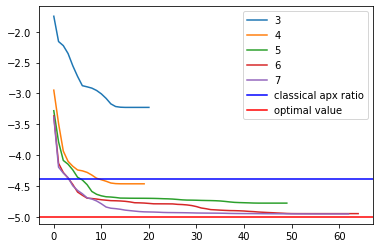

In [ ]:
T = 10.

for nlayers in range(3,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []

    for k in range(nlayers): #here, nlayers is equal to p
      parameters_init.append(1/2*T/nlayers*(1-(k+1)/nlayers))
      parameters_init.append(1/2*T/nlayers*(k+1)/nlayers)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

The convergence is faster (approximately 35 loop for optimizing the paramaters) and require less layers (here 6). 